# Details of an Example Use Case

The example_BIDS.py file is a Python script that illustrates how the user would use the py_neuromodulation software. In this notebook, we take this example and go over it step by step, in order to give a better intuition behind each step.

We start with importing the necessary packages:

In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if SCRIPT_DIR.split("/")[-1] == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
)
from sklearn import metrics, model_selection
from skopt import space as skopt_space

## Read BIDS data

The first step in any use case is loading the data. Here, we show how the user would load data that is stored in the BIDS format, using the function nm_IO.read_BIDS_data().

py_neuromodulation can perform feature estimation and decoding in other types of data, but the user is responsible for the loading step and for guaranteeing that all necessary information is provided. In the next steps we point out which information all datasets must contain in order to use the pipeline.

In [3]:
sub = "testsub"
ses = "EphysMedOff"
task = "buttonpress"
run = 0
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")

# Provide a path for the output data.
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives")

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.


##  Define the channels

BIDS data is saved in BrainVision format, which consists of three separate files:

- A text header file (.vhdr) containing meta data
- A text marker file (.vmrk) containing information about events in the data
- A binary data file (.eeg) containing the voltage values of the EEG (or as in our case, iEEG)

The MNE-BIDS Python library reads this data and stores it in a MNE-Python Raw object.

This Raw object has as attribute the channel names, and as a method get_channel_types, that returns a list of channel type for each channel.

The Raw object also stores the measurement information in raw.info, where one can also access the bad channels, i.e, a list of noisy/broken channels, by name. These channels will by default be ignored by many processing steps.

__If the user insert by hand the list of channel names, their respective types and the information on which are the bad ones, any type of data can be used, not necessarily in the BIDS format.__

Here "SQUARED_ROTATION" is used as target channel. After feature estimation, this channel will be normalized and added in a time aligned manner to the features output csv file.

In [5]:
nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=("SQUARED_ROTATION",),
)

## Feature Estimation

nm.Stream is where the magic happens. It is the class that handles all feature estimation steps. First we create an instance of that class, and then use the set_settings_fast_compute function to only select fft features and a minimal set of rereferencing, normalization, notch filtering and post processing normalization methods.

In [6]:
stream = nm.Stream(
    settings=None,
    nm_channels=nm_channels,
    path_grids=None,
    verbose=True,
)

stream.set_settings_fast_compute()

In the cell below, if the user provides sfreq, line_noise, coord_list and coord_names, then there's no need for data in BIDS format.

In stream.run the data should also be manually inserted.

In [7]:
stream.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

Last batch took: 0.02 seconds
1.0 seconds of data processed
Last batch took: 0.01 seconds
1.1 seconds of data processed
Last batch took: 0.02 seconds
1.2 seconds of data processed
Last batch took: 0.02 seconds
1.3 seconds of data processed
Last batch took: 0.01 seconds
1.4 seconds of data processed
Last batch took: 0.01 seconds
1.5 seconds of data processed
Last batch took: 0.01 seconds
1.6 seconds of data processed
Last batch took: 0.01 seconds
1.7 seconds of 

As soon as the command stream.run() above is executed, the feature estimation step is done and the results are saved in the BIDS format into the /py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/ directory.

The features are in a file _FEATURES.csv
The used channels are stored in nm_channels.csv
The settings chosen are in _SETTINGS.json
Additional information that is not part of settings nor channels is stored in _SIDECAR.json



## Analysing results

We can now analyse the results of the feature estimation using the Feature_Reader class. All features are estimated for each channel. For now, we plot results for only one ECoG channel.

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_ECOG_L_1_SMC_AT_fft.png


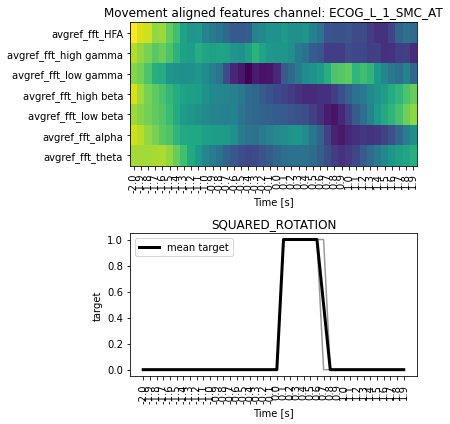

In [8]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = feature_reader.nm_channels.query(
    '(type=="ecog") and (used == 1)'
).iloc[0]["name"]

feature_used = (
    "stft" if feature_reader.settings["features"]["stft"] else "fft"
)

feature_reader.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

In the first plot we see how the features change before, during and after movement. The time axis of the features is aligned to the target channel.

The function plot_target_averaged_channel() receives a threshold as optional input, for the case where the target is continuous, for example, a rotation movement. In that case, we need to threshold it somehow to get an "event", in which respect we can plot the features. For our case, it simplifies the problem to different classes and for t=0 a different class onsets, as we can see in the second plot, showing the target plotted for all events where it crossed the threshold.

The lighter plot is the individual movement trace, and the thicker one is the average.

The plot is saved as a .png in the /py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/ directory.
CCA

## Decoding

The main focus of the py_neuromodulation pipeline is the feature estimation. Nevertheless, the user can also use the pipeline for Machine Learning decoding. It can be used for regression and classification problems, and also for unsupervised methods, such as PCA and CCA.

Here we show an example using the XGBOOST Classifier. The labels used come from the target, in this case, the "SQUARED_ROTATION".

The performance results are saved and plotted below. Again the figure is saved as a .png in the /py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/ directory.

no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_LM_ML_RES.p


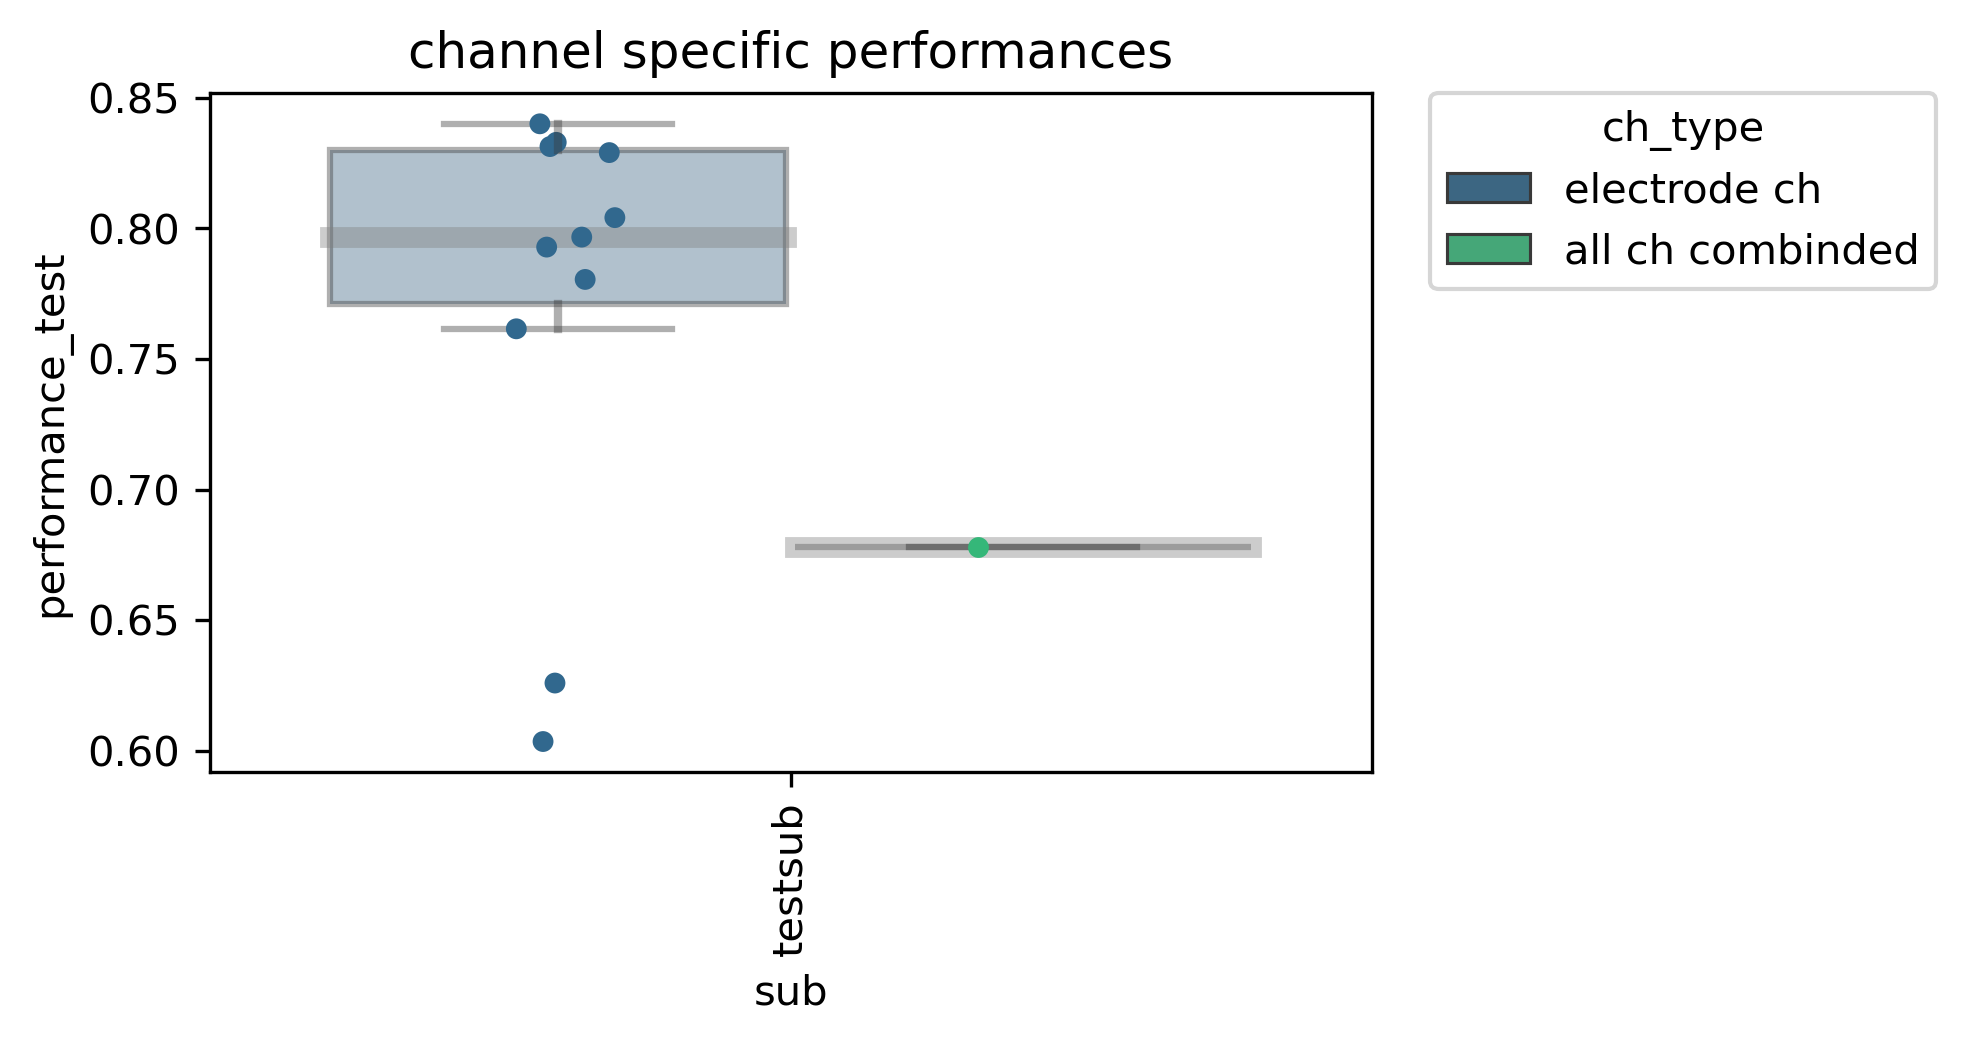

In [9]:
model = xgboost.XGBClassifier(use_label_encoder=False)

bay_opt_param_space = [
    skopt_space.Integer(1, 100, name="max_depth"),
    skopt_space.Real(
        10 ** -5, 10 ** 0, "log-uniform", name="learning_rate"
    ),
    skopt_space.Real(10 ** 0, 10 ** 1, "uniform", name="gamma"),
]

feature_reader.decoder = nm_decode.Decoder(
    features=feature_reader.feature_arr,
    label=feature_reader.label,
    label_name=feature_reader.label_name,
    used_chs=feature_reader.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    bay_opt_param_space=bay_opt_param_space,
    use_nested_cv=True,
    sfreq=feature_reader.settings["sampling_rate_features_hz"],
)

performances = feature_reader.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per = feature_reader.get_dataframe_performances(performances)

nm_plots.plot_df_subjects(
    df_per, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance.png")
)

### References

Holdgraf, C., Appelhoff, S., Bickel, S. et al. iEEG-BIDS, extending the Brain Imaging Data Structure specification to human intracranial electrophysiology. Sci Data 6, 102 (2019). https://doi.org/10.1038/s41597-019-0105-7

Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software, 4:1896. DOI: 10.21105/joss.01896

https://www.brainproducts.com/support-resources/brainvision-core-data-format-1-0/